In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from hcipy import *
from tqdm import trange



**Now we are ready to begin! The first step is to define our telescope aperture and wavelength.**

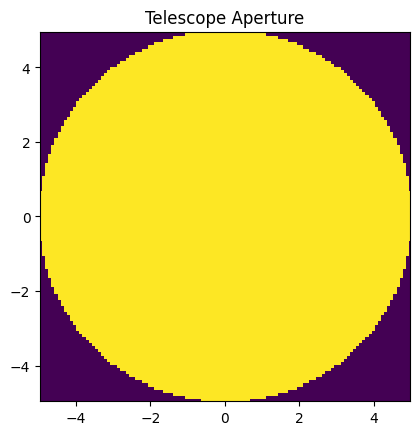

In [2]:
#setup the basic elements in hcipy.

grid_size=120 #define number of pixels across our telescope aperture.
D=10  #define the telescope diameter in meters.
pupil_grid = make_pupil_grid(grid_size, diameter=D)  #define our aperture grid (pupil grid)
telescope_aperture  = make_circular_aperture(D)  #this is a function that returns a telescope aperture. Note this is a function.
telescope_pupil=telescope_aperture(pupil_grid)   #telescope aperture (primary mirror)

plt.figure()
imshow_field(telescope_pupil)  # hcipy has a fancy version of plt.imshow() that are for Fields
plt.title('Telescope Aperture')
plt.show()

#pick our wavelength to use for the simulation
wavelength=2.6e-6
k=2*np.pi/wavelength #wavenumber. Converts between microns and radians

**Now we need to make our wavefront object** (our electric field) that we can propogate through the optics.

In [3]:
wf= Wavefront(telescope_pupil,wavelength=wavelength) #electric field in hcipy
wf.total_power = 1

**After our AO system, we want to propogate our wavefront to the focal plane** (i.e., imaging plane). This is done via a fourier transform. HCIPY does this efficiently using the FraunhoferPropagator object, so we don't have to worry about computational effects.

By propogating a wavefront to the focal plane we can get our point-spread-function that is the intensity component of the propagated wavefront.

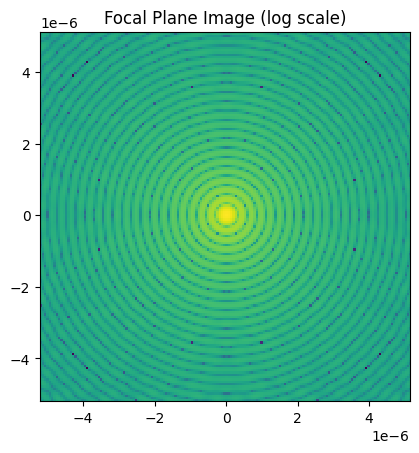

In [4]:
focal_grid = make_focal_grid(q=4, num_airy=20,spatial_resolution=wavelength/D) # how we want to sample the grid that our psf will be on...think of this like our camera
propagator = FraunhoferPropagator(pupil_grid, focal_grid)  #this encodes our fourier transform as it propagates things from the telescope to our focus.

#reference image and the max for plotting the psf later as well as strehl ratio calculation
im_ref= propagator.forward(wf)
norm= np.max(im_ref.intensity)

plt.figure()
plt.title('Focal Plane Image (log scale)')
imshow_field(np.log10(im_ref.intensity/norm)) # this displays our reference PSF image. Since the wavefront is flat and we're using a circular telescope aperture, this is a perfect Airy disk.
plt.show()

**Now that we've set up our telescope, wavefront, and propagrator, we can also set up the atmospheric turbulence that our AO system will correct.**

We need 3 parameters to model a single layer of atmospheric turbulence:
1. Fried parameter, r0 (meters)
2. Outer_scale, L0 (meters)
3. Wind velocity, v (meters/second)


In [5]:
 #Here we are going to make our atmospheric turublence model using HCIPy.

# let's pick the properties of our turblence
fried_parameter = 0.05
outer_scale = 50
velocity = 10.0
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter)  #convert the fried parameter into Cn2

# make our atmospheric turbulence layer
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity, seed=371)

**We now set up our deformable mirror (DM).**


In [6]:
#make the DM
num_actuators = 20

actuator_spacing = D / num_actuators
influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators, actuator_spacing)
deformable_mirror = DeformableMirror(influence_functions)


**We now set up our wavefront sensor. Here, this is a pyramid wavefront sensor**


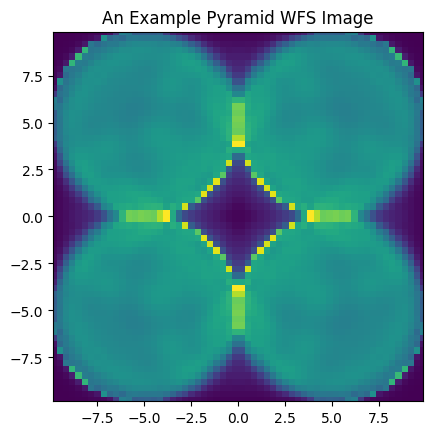

In [7]:
# set up pyramid wavefront sensor
pixels_pyramid_pupils=30 # number of pixels across each pupil; want 120 %(mod) pixels_pyramid_pupils =0. VARY THIS PARAMETER
pwfs_grid = make_pupil_grid(pixels_pyramid_pupils*2, D*2)

mld=5 # modulation radius in lambda/D (we will discuss modulation in a future lecture. Do not vary.)
modradius = mld*wavelength/D # modulation radius in radians;
modsteps = 12 # keep this as a factor of 4. Increasing this value significantly increases the computation time. No need to change today.

pwfs = PyramidWavefrontSensorOptics(pupil_grid, pwfs_grid, separation=D, wavelength_0=wavelength)
mpwfs = ModulatedPyramidWavefrontSensorOptics(pwfs,modradius,modsteps)
wfs_camera = NoiselessDetector(pwfs_grid)

# #commands to modulate the PyWFS, get an image out, and calculate a reference
for m in range (modsteps) :
      wfs_camera.integrate(mpwfs(wf)[m], 1)

image_ref = wfs_camera.read_out()
image_ref /= image_ref.sum()

plt.figure()
plt.title('An Example Pyramid WFS Image')
imshow_field(image_ref)
plt.show()

In [8]:
# @title Do not click on this -- it contains hidden code that you'll write your own version of in a later assignment
def make_command_matrix(deformable_mirror, mpwfs,modsteps,wfs_camera,wf,pixels_pyramid_pupils):
  probe_amp = 0.01 * wf.wavelength
  num_modes=deformable_mirror.num_actuators
  slopes = []

  for ind in trange(num_modes):
      slope = 0

      # Probe the phase response
      for s in [1, -1]:
          amp = np.zeros((num_modes,))
          amp[ind] = s * probe_amp
          deformable_mirror.actuators = amp

          dm_wf = deformable_mirror.forward(wf)

          for m in range (modsteps) :
                wfs_camera.integrate(mpwfs(dm_wf)[m], 1)

          image = wfs_camera.read_out()
          image /= np.sum(image)

          slope += s * (image-image_ref)/(2 * probe_amp)

      slopes.append(slope)

  slopes = ModeBasis(slopes)

  rcond = 1E-3
  command_matrix = inverse_tikhonov(slopes.transformation_matrix, rcond=rcond, svd=None)
  return command_matrix

The command matrix is an important part of an AO controller. The command matrix relates the wavefront sensor to the DM such that we can take a wavefront senor image and transform it into DM actuator positions. This step uses the hidden code above.

In [9]:
#Make command matrix for controller -- this takes a few minutes to run.
#This code will have to be rerun everytime you change a value related to the WFS or DM.
#Just run this code & do not peak at the function that does the work for you (we'll come back to this in another assignment).
CM=make_command_matrix(deformable_mirror, mpwfs, modsteps,wfs_camera,wf,pixels_pyramid_pupils)

100%|██████████| 400/400 [09:19<00:00,  1.40s/it]


**We now need to set the parameters for our leaky integrator controller.** Today, we won't change the leak term and the gain. **We will vary the speed of our AO system, dt.** AO systems can run at various rates with typical values ranging from 500-1000Hz.



In [18]:
#leaky integrator parameters (we will vary these in a future assignment)
gain = 0.2
leakage = 1.0

#AO loop speed: VARY THIS PARAMETER
dt=1./800


**It is now time to run our simulation!** We can save it into an .mp4 file saving every few frames or wait until the end (sufficient frames for the AO system to settle down, aka AO burn in time) and save the last frame as a .png to get a nice representative frame of the system's behavior.

At each timestep we need to do the following order of operations:
1. Get a wavefront that hasnt yet been aberrated
2. Evolve the turbulence to the current time step
3. The wavefront passes through atmospheric turbulence
4. The wavefront gets partially corrected by the current shape on the DM
5. The wavefront now containing the residual wavefront error gets passed to the WFS
6. Reconstruct the wavefront
7. Calculate the new DM commands via the leaky integrator
8. Propagrate the residual wavefront to the focal plane

The following section may take a few minutes to run (it takes ~2 minutes for me).

100%|██████████| 200/200 [01:07<00:00,  2.98it/s]


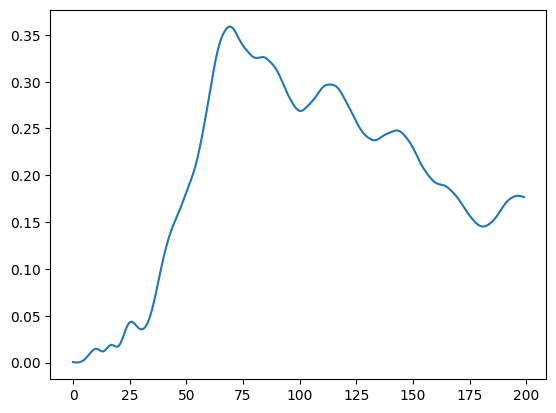

In [19]:
num_iterations = 200 #number of time steps in our simulation. We'll run for a total of dt*num_iterations seconds
sr=[] # so we can find the average strehl ratio
layer.reset()
layer.t = 0
deformable_mirror.flatten()
for timestep in trange(num_iterations):
    #get a clean wavefront
    wf_in=wf.copy()

    #evolve the atmospheric turbulence
    layer.t = timestep*dt

    #pass the wavefront through the turbulence
    wf_after_atmos = layer.forward((wf_in))

    #pass the wavefront through the DM for correction
    wf_after_dm = deformable_mirror.forward(wf_after_atmos)

    #send the wavefront containing the residual wavefront error to the PyWFS and get slopes
    wfs_wf = mpwfs.forward(wf_after_dm)
    for mmm in range (modsteps) :
              wfs_camera.integrate(wfs_wf[mmm], dt/modsteps)
    wfs_image = wfs_camera.read_out()
    wfs_image /= np.sum(wfs_image)
    diff_image = wfs_image - image_ref


    #Leaky integrator to calculate new DM commands
    deformable_mirror.actuators =  leakage*deformable_mirror.actuators - gain * CM.dot(diff_image)

    # Propagate to focal plane
    wf_focal = propagator.forward(wf_after_dm )

    #calculate the strehl ratio to use as a metric for how well the AO system is performing.
    strehl_foc=get_strehl_from_focal(wf_focal.intensity/norm,im_ref.intensity/norm)
    sr.append(strehl_foc)

plt.plot(sr)